<a href="https://colab.research.google.com/github/Raysk1/machineLearning/blob/main/PROYECTO-04-FRANCO-GARCIA-OSCAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando Librerias


In [ ]:
!pip install selenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install skforecast


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached selenium-4.4.2-py3-none-any.whl (985 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached trio-0.21.0-py3-none-any.whl (358 kB)
  Using cached trio_websocket-0.9.2-py3-none-any.whl (16 kB)
  Using cached urllib3-1.26.11-py2.py3-none-any.whl (139 kB)
  Using cached sniffio-1.2.0-py3-none-any.whl (10 kB)
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
  Using cached outcome-1.2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached wsproto-1.1.0-py3-none-any.whl (24 kB)
  Using cached h11-0.13.0-py3-none-any.whl (58 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.6.15
    Uninstalling certifi-2022.6.15:
      Successfully uninstalled certifi-2022.6.15
E

In [ ]:
import sys
from selenium import webdriver
import pandas as pd
import numpy as np
from selenium.webdriver.common.by import By
import glob
from datetime import datetime
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from selenium.webdriver.support.ui import Select


#Realizando Web Scraping

In [ ]:

#Configurando el webdriver
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_experimental_option('prefs', {
"download.default_directory": "/content/data", #Directorio de descargas
"download.prompt_for_download": False, #Autodescarga
"download.directory_upgrade": True,
"plugins.always_open_pdf_externally": True})
wd = webdriver.Chrome('chromedriver',options=chrome_options)


In [ ]:
#Accediendo ala pagina de INEGI de nuestro interes
wd.get("https://www.inegi.org.mx/app/tabulados/default.html?nc=100100090_a")
#Seleccionando 2005 en el menu de opcione de fecha para que carge contetinode 2005 a 2022
select = Select(wd.find_element(By.NAME,"cmbperiodo1"))
select.select_by_visible_text("2005")
#Pulsando el boton consultar para que muestre la nueva informacion
wd.find_element(By.CSS_SELECTOR, "div#cp button.btn").click()

In [ ]:
#Identificando los nombres de las columnas
columns = wd.find_elements(By.CSS_SELECTOR, "thead tr.cabecera th")
from numpy.ma.core import append
columns_name = ["Año","Mes"]
for col in columns:
  if col.text != "":
    columns_name.append(col.text)

print(columns_name)

['Año', 'Mes', 'Venta', 'Producción', 'Exportación']


In [ ]:
#Obteniendo las filas de la tabla
trs = wd.find_elements(By.CSS_SELECTOR,"table#tech-companies-1 tbody.notranslate tr")

data = []
data_temp = []
año = 0

#Procesando la informacion
for tr in trs:
  #En th se encuentra el año
  data_raw = tr.find_elements(By.TAG_NAME,"th")

  #Si no hay th Significa que son datos
  if len(data_raw) == 0:
    data_temp.append(año)
    data_raw = tr.find_elements(By.TAG_NAME,"td")
    for td in data_raw:
      data_temp.append(td.text)
    data.append(data_temp.copy())
    data_temp.clear()
  else:
    año = data_raw[0].text
  
#Se crea dataframe con la informacion obtenida
df = pd.DataFrame(data,columns= columns_name)

In [ ]:
df = pd.DataFrame(data,columns= columns_name)

#Analisis Exploratorio

In [ ]:
df.head()

,Año,Mes,Venta,Producción,Exportación
0,2005,Enero,"93,299","91,928","61,692"
1,2005,Febrero,"89,444","126,635","89,341"
2,2005,Marzo,"89,483","115,651","81,043"
3,2005,Abril,"86,426","135,057","100,964"
4,2005,Mayo,"83,962","131,296","98,754"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Año          211 non-null    object
 1   Mes          211 non-null    object
 2   Venta        211 non-null    object
 3   Producción   211 non-null    object
 4   Exportación  211 non-null    object
dtypes: object(5)
memory usage: 8.4+ KB


In [ ]:
#Retirando las comas de los datos numericos
df["Venta"] = df["Venta"].str.replace(",","")
df["Producción"] = df["Producción"].str.replace(",","")
df["Exportación"] = df["Exportación"].str.replace(",","")

df.head()

,Año,Mes,Venta,Producción,Exportación
0,2005,Enero,93299,91928,61692
1,2005,Febrero,89444,126635,89341
2,2005,Marzo,89483,115651,81043
3,2005,Abril,86426,135057,100964
4,2005,Mayo,83962,131296,98754


In [ ]:
#Convirtiendo los valores a numericos
df["Venta"] = pd.to_numeric(df["Venta"])
df["Producción"] = pd.to_numeric(df["Producción"])
df["Exportación"] = pd.to_numeric(df["Exportación"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Año          211 non-null    object
 1   Mes          211 non-null    object
 2   Venta        211 non-null    int64 
 3   Producción   211 non-null    int64 
 4   Exportación  211 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 8.4+ KB


In [ ]:
month = {	'ENERO' : '01',
          'FEBRERO' :'02',
          'MARZO' : '03',
          'ABRIL' : '04',
          'MAYO' : '05',
          'JUNIO' : '06',
          'JULIO' : '07',
          'AGOSTO' : '08',
          'SEPTIEMBRE' : '09',
          'OCTUBRE' : '10',
          'NOVIEMBRE' : '11',
          'DICIEMBRE' : '12'		}

#Uniendo el mes y año en un solo campo
df["Mes"] = df["Mes"].str.upper()
df.replace({"Mes" : month}, inplace=True)
df["Fecha"] = df["Mes"].str.cat("/" + df["Año"])
df["Fecha"] = pd.to_datetime(df["Fecha"],format="%m/%Y")
df.drop(["Año","Mes"], axis = 1, inplace=True)
df.head()

,Venta,Producción,Exportación,Fecha
0,93299,91928,61692,2005-01-01
1,89444,126635,89341,2005-02-01
2,89483,115651,81043,2005-03-01
3,86426,135057,100964,2005-04-01
4,83962,131296,98754,2005-05-01


In [ ]:
#Estableciendo como index el campo fecha 
df.set_index("Fecha",inplace=True)
#Estacleciendo la freq
df = df.asfreq(freq='M', method='ffill')
df.head()

,Venta,Producción,Exportación
Fecha,,,
2005-01-31,93299,91928,61692
2005-02-28,89444,126635,89341
2005-03-31,89483,115651,81043
2005-04-30,86426,135057,100964
2005-05-31,83962,131296,98754


In [ ]:
#Mostrando diferentes metricas
df.describe()

,Venta,Producción,Exportación
count,210.000000,210.000000,210.000000
mean,94252.690476,234913.157143,195524.771429
std,23606.919009,73843.836706,65710.083704
min,34927.000000,3722.000000,15139.000000
25%,78838.250000,178935.250000,144289.000000
50%,88883.500000,242028.500000,200766.500000
75%,109672.250000,287452.000000,241141.750000
max,192741.000000,382110.000000,327454.000000


#Entrenando el modelo

In [ ]:
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

Fechas train : 2005-01-31 00:00:00 --- 2019-07-31 00:00:00  (n=175)
Fechas test  : 2019-08-31 00:00:00 --- 2022-06-30 00:00:00  (n=35)


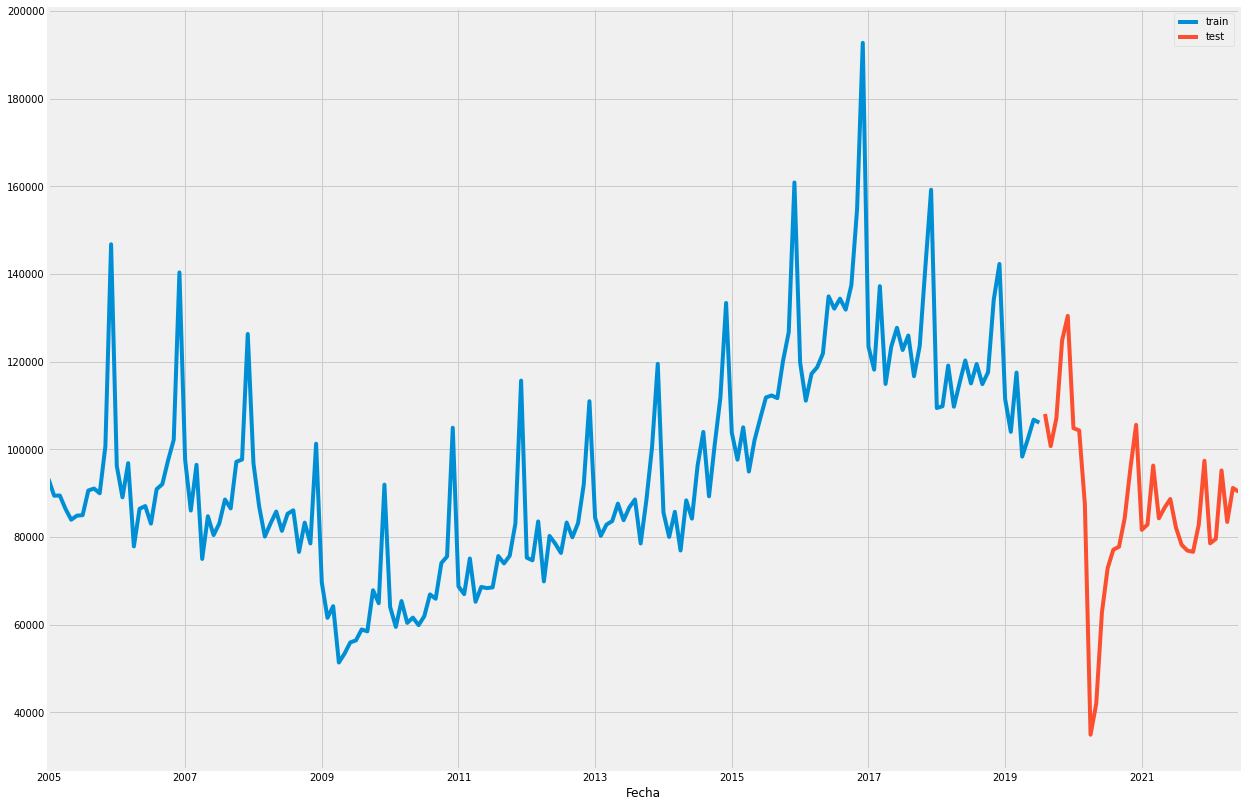

In [ ]:
%matplotlib inline
steps = 35
datos_train = df[:-steps]
datos_test  = df[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(19, 14))
datos_train['Venta'].plot(ax=ax, label='train')
datos_test['Venta'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(random_state=123)),
                lags      = 14
             )

forecaster.fit(y=datos_train.Venta)
forecaster

ForecasterAutoreg 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(random_state=123))]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2005-01-31 00:00:00'), Timestamp('2019-07-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': 123, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 
Creation date: 2022-08-18 05:32:18 
Last fit date: 2022-08-18 05:32:18 
Skforecast version: 0.4.3 

In [ ]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Venta,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            refit      = False,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 175
Number of observations used for backtesting: 35
    Number of folds: 1
    Number of steps per fold: 35

Data partition in fold: 0
    Training:   2005-01-31 00:00:00 -- 2019-07-31 00:00:00
    Validation: 2019-08-31 00:00:00 -- 2022-06-30 00:00:00

Error backtest: 14542.456636001467


,pred
2019-08-31,108181.018958
2019-09-30,104438.013781
2019-10-31,107914.851916
2019-11-30,123404.857835
2019-12-31,127580.077852


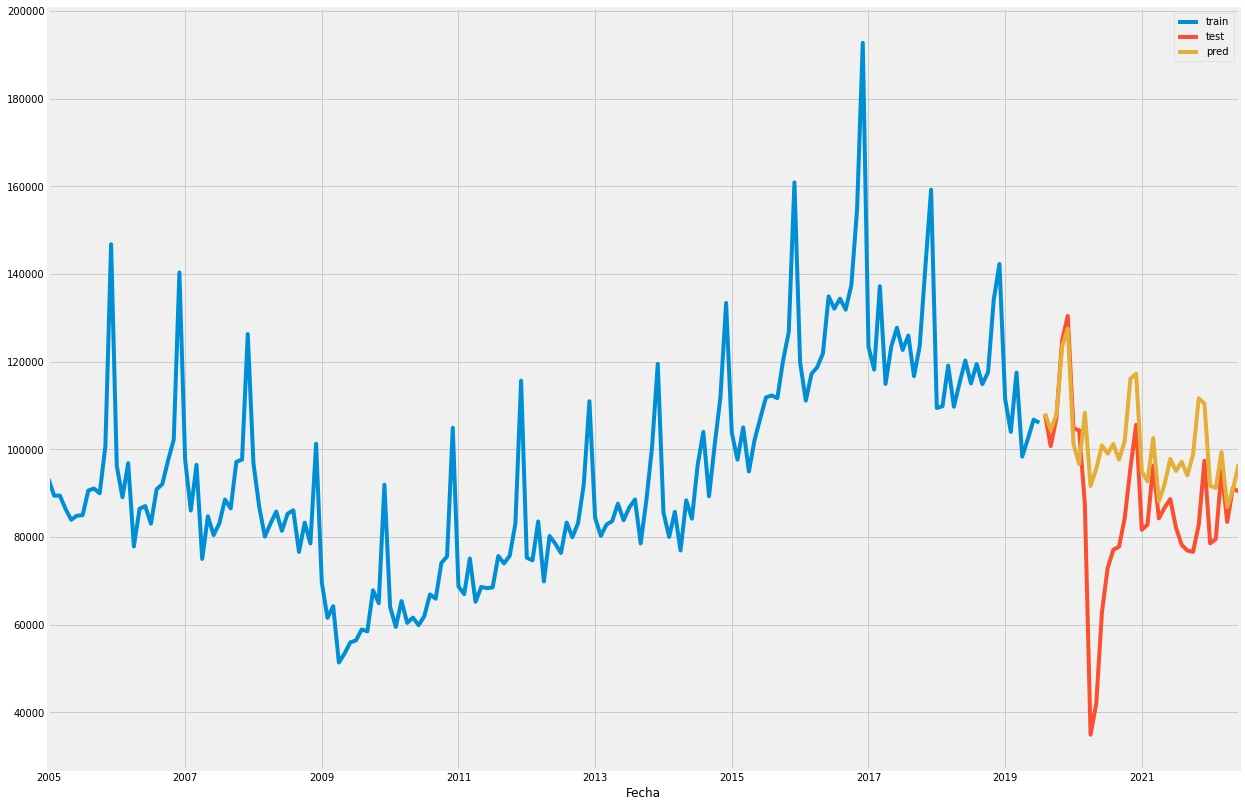

In [ ]:
fig, ax = plt.subplots(figsize=(19, 14))
datos_train['Venta'].plot(ax=ax, label='train')
datos_test['Venta'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Ridge(random_state=123)),
                lags      = 12
             )

# Hiperparámetros del regresor: al utilizar un pipeline, el nombre del hiperparámetro
# va precedido por el nombre del regressor.
param_grid = {'ridge__alpha': np.logspace(-10, 10, 200)}

# Lags utilizados como predictores
lags_grid = range(1,80)

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df.Venta,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 15800


loop lags_grid: 100%|█████████████████████████████████████| 79/79 [06:50<00:00,  5.20s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
  Parameters: {'ridge__alpha': 1e-10}
  Backtesting metric: 241173609.31971467



In [ ]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.Venta,
                            initial_train_size = len(datos_train),
                            steps      = steps,
                            refit      = False,
                            metric     = 'mean_absolute_error',
                            verbose    = True
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 175
Number of observations used for backtesting: 35
    Number of folds: 1
    Number of steps per fold: 35

Data partition in fold: 0
    Training:   2005-01-31 00:00:00 -- 2019-07-31 00:00:00
    Validation: 2019-08-31 00:00:00 -- 2022-06-30 00:00:00

Error backtest: 11081.080903171201


,pred
2019-08-31,104849.640280
2019-09-30,99256.341135
2019-10-31,104780.987265
2019-11-30,113545.058297
2019-12-31,124552.134958


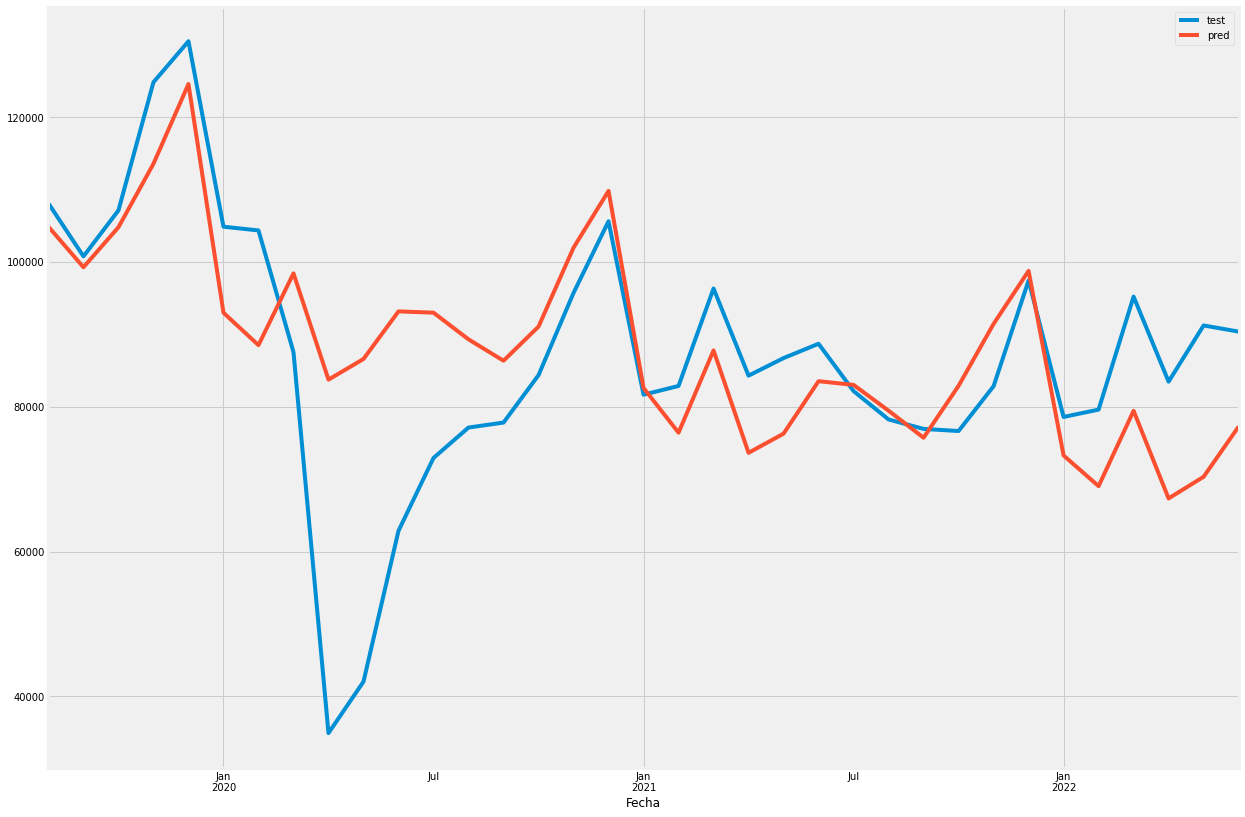

In [ ]:
fig, ax = plt.subplots(figsize=(19, 14))
#datos_train['Venta'].plot(ax=ax, label='train')
datos_test['Venta'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

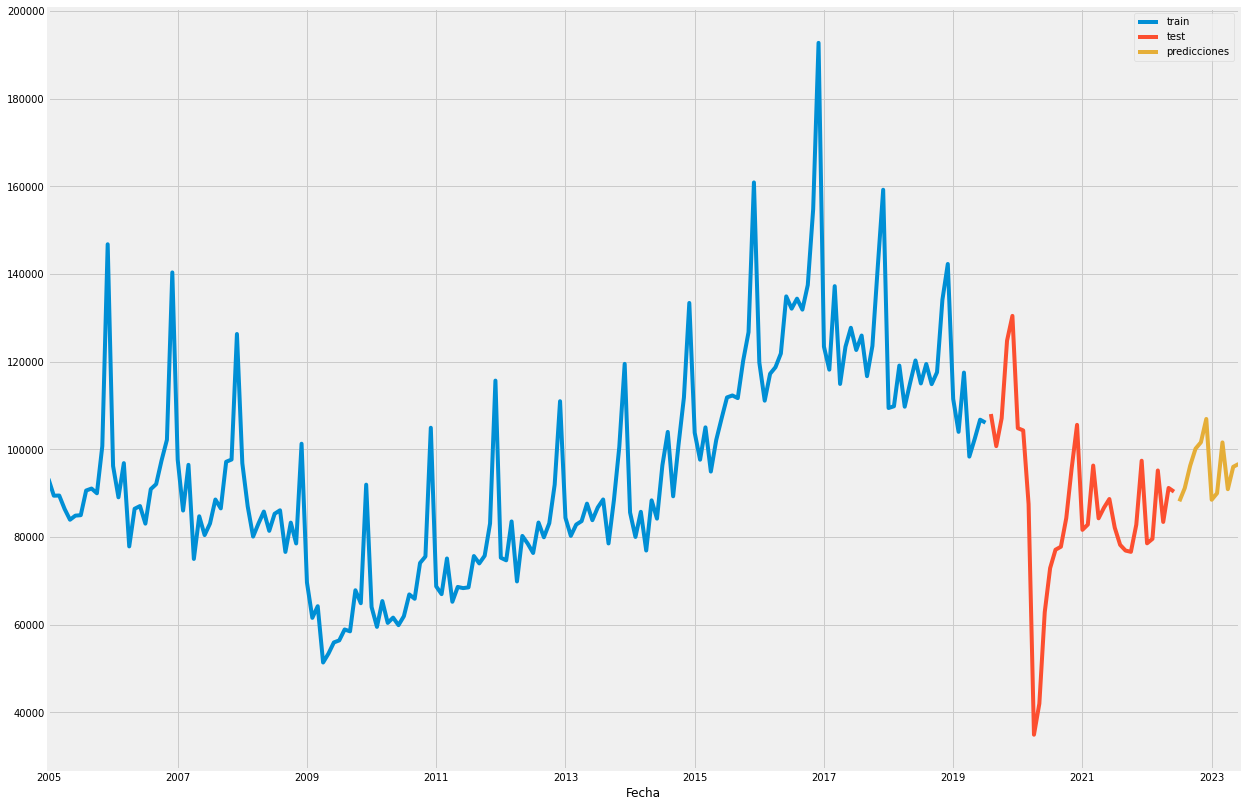

In [ ]:
predicciones = forecaster.predict(12)

fig, ax = plt.subplots(figsize=(19, 14))
datos_train['Venta'].plot(ax=ax, label='train')
datos_test['Venta'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();